In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from glob import glob
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt

In [3]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from fbprophet import Prophet
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance, plot_metric, plot_tree

from sklearn.metrics import mean_squared_error

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [5]:
dataset = pd.read_pickle('../data/m5_preprocessed.pkl')

In [6]:
dataset['id'] = dataset['id'].astype(str).astype('category')

In [16]:
dataset.rename(columns={'sales': 'sold'}, inplace = True)
dataset

,id,d,sold,date,weekday
0,CA_1_FOODS_1,1,297,2011-01-29,Saturday
1,CA_1_FOODS_1,2,284,2011-01-30,Sunday
2,CA_1_FOODS_1,3,214,2011-01-31,Monday
3,CA_1_FOODS_1,4,175,2011-02-01,Tuesday
4,CA_1_FOODS_1,5,182,2011-02-02,Wednesday
...,...,...,...,...,...
133905,WI_3_HOUSEHOLD_2,1909,148,2016-04-20,Wednesday
133906,WI_3_HOUSEHOLD_2,1910,142,2016-04-21,Thursday
133907,WI_3_HOUSEHOLD_2,1911,166,2016-04-22,Friday
133908,WI_3_HOUSEHOLD_2,1912,232,2016-04-23,Saturday


In [7]:
def mape(y, y_hat):
    y_d = y + 0.1
    score = (np.abs(y - y_hat) / np.abs(y_d)).sum() * 100 / y.shape[0]
    return score

In [8]:
def rmse(y, y_hat):
    return mean_squared_error(y, y_hat)**0.5

In [9]:
def rmsse(y_true: np.ndarray, y_pred: np.ndarray, y_hist: np.ndarray) -> float:
    h, n = len(y_true), len(y_hist)

    numerator = np.sum((y_true - y_pred)**2)
    denominator = 1/(n-1)*np.sum((y_hist[1:] - y_hist[:-1])**2)

    rmsse = np.sqrt(1/h * numerator/denominator)
    return rmsse

In [10]:
period = 10

## (1) Simple Moving Average

In [17]:
window = 15
df_list = []

for identifier, sliced in dataset.groupby(['id']):
    num_entries = len(sliced)
    
    if num_entries > period:
        sliced_copy = sliced.copy()

        sma = sliced_copy.sold.rolling(window=window).mean()
        sliced_copy['SMA'] = sma

        df_list.append(sliced_copy)
        
df_1 = pd.concat(df_list, axis=0)

In [53]:
df_1

,id,d,sold,date,weekday,SMA
0,CA_1_FOODS_1,1,297,2011-01-29,Saturday,NaN
1,CA_1_FOODS_1,2,284,2011-01-30,Sunday,NaN
2,CA_1_FOODS_1,3,214,2011-01-31,Monday,NaN
3,CA_1_FOODS_1,4,175,2011-02-01,Tuesday,NaN
4,CA_1_FOODS_1,5,182,2011-02-02,Wednesday,NaN
...,...,...,...,...,...,...
133905,WI_3_HOUSEHOLD_2,1909,148,2016-04-20,Wednesday,157.533333
133906,WI_3_HOUSEHOLD_2,1910,142,2016-04-21,Thursday,158.733333
133907,WI_3_HOUSEHOLD_2,1911,166,2016-04-22,Friday,161.333333
133908,WI_3_HOUSEHOLD_2,1912,232,2016-04-23,Saturday,165.600000


In [68]:
len(dataset['id'].unique())

70

IndexError: index 15 is out of bounds for axis 0 with size 15

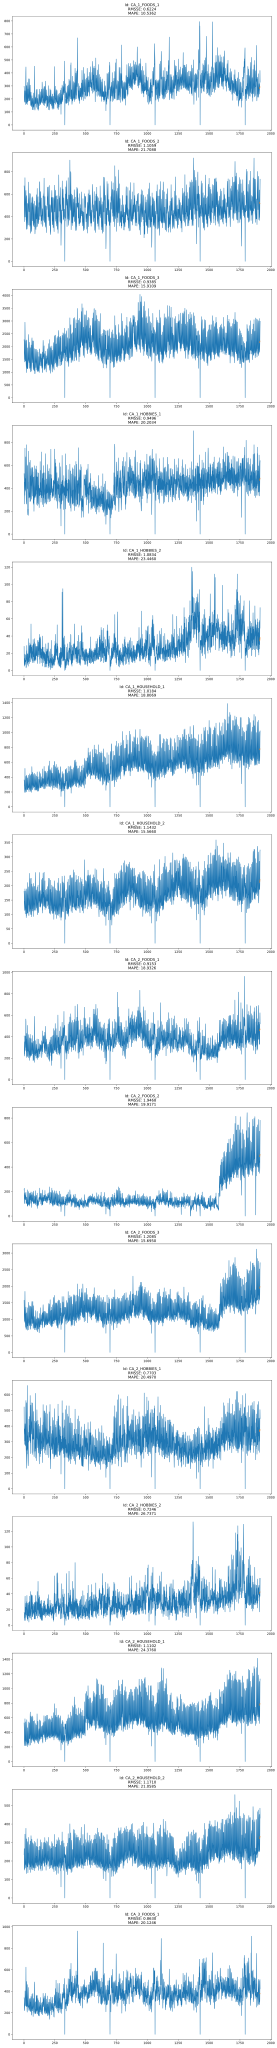

In [57]:
samples = 7

f, ax = plt.subplots(nrows=samples, ncols=1, figsize=(15,8*samples))

i = 0

sma_mape = []
sma_rmsse = []

for identifier, sliced in df_1.groupby(['id']):
    ax[i].plot(sliced.d, sliced.sold)
    ax[i].plot(sliced.d[-5:], sliced.SMA[-5:])
    
    rsse = rmsse(y_true=np.array(sliced.sold[-period:]), y_pred=np.array(sliced.SMA[-period:]), y_hist=np.array(sliced.sold))
    sma_rmsse.append(rsse)    
    me = mape(np.array(sliced.sold[-period:]), np.array(sliced.SMA[-period:]))
    sma_mape.append(me)
    
    ax[i].set_title(f'Id: {identifier}\nRMSSE: {rsse:.4f}\nMAPE: {me:.4f}')
    
    i += 1

# f.savefig('./SMA.pdf')

In [20]:
sma_mape

[10.53622484819284,
 21.708789312140237,
 15.910939152892052,
 20.20339843544904,
 23.445992753749742,
 18.806865018170797,
 15.565984622921452,
 18.932581018219235,
 19.917053806868417]

In [21]:
np.array(sma_mape).mean()

18.336425440955978

## (2) Exponential Smoothing

### (2-1) Simple Exponential Smoothing

In [34]:
prediction_des = {}

for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries > 120:
        fit = SimpleExpSmoothing(sliced.sold, initialization_method="estimated").fit()
        forecast_1 = fit.forecast(period)
        prediction_des[identifier] = forecast_1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An

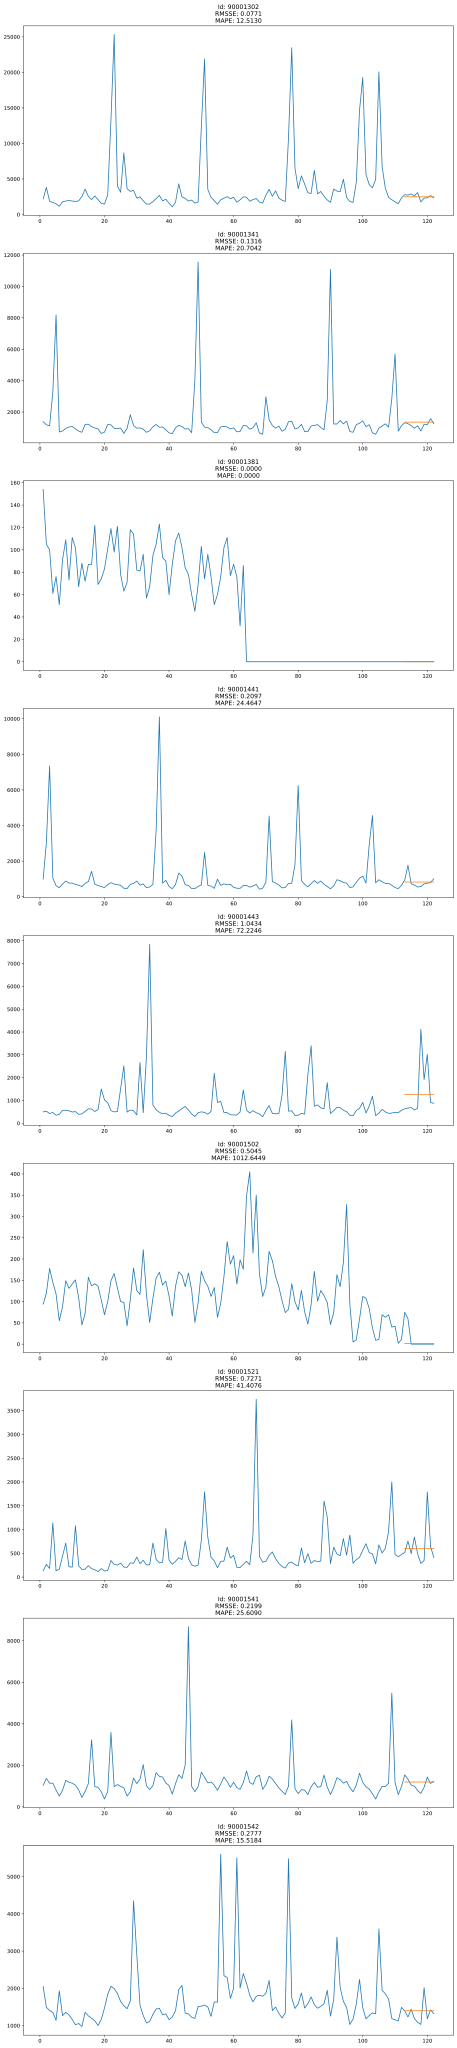

In [35]:
samples = len(prediction_des)

f, ax = plt.subplots(nrows=samples, ncols=1, figsize=(15,8*samples))

i = 0
ses_mape = []
ses_rmsse = []
for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries > 120:
        ax[i].plot(sliced.d, sliced.sold)
        ax[i].plot(sliced.d[-period:], prediction_des[identifier])
        
        rsse = rmsse(y_true=np.array(sliced.sold[-period:]), y_pred=prediction_des[identifier].values, 
                     y_hist=np.array(sliced.sold))
        ses_rmsse.append(rsse)    
        me = mape(np.array(sliced.sold[-period:]), prediction_des[identifier].values)
        ses_mape.append(me)
        
        ax[i].set_title(f'Id: {identifier}\nRMSSE: {rsse:.4f}\nMAPE: {me:.4f}')

        i += 1
        

# f.savefig('./SES.pdf')

### (2-2) Double Exponential Smoothing

In [36]:
prediction_des = {}

for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries > 120:
        fit = ExponentialSmoothing(sliced.sold, seasonal_periods=12).fit()
        forecast_1 = fit.forecast(period)
        prediction_des[identifier] = forecast_1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning:

An

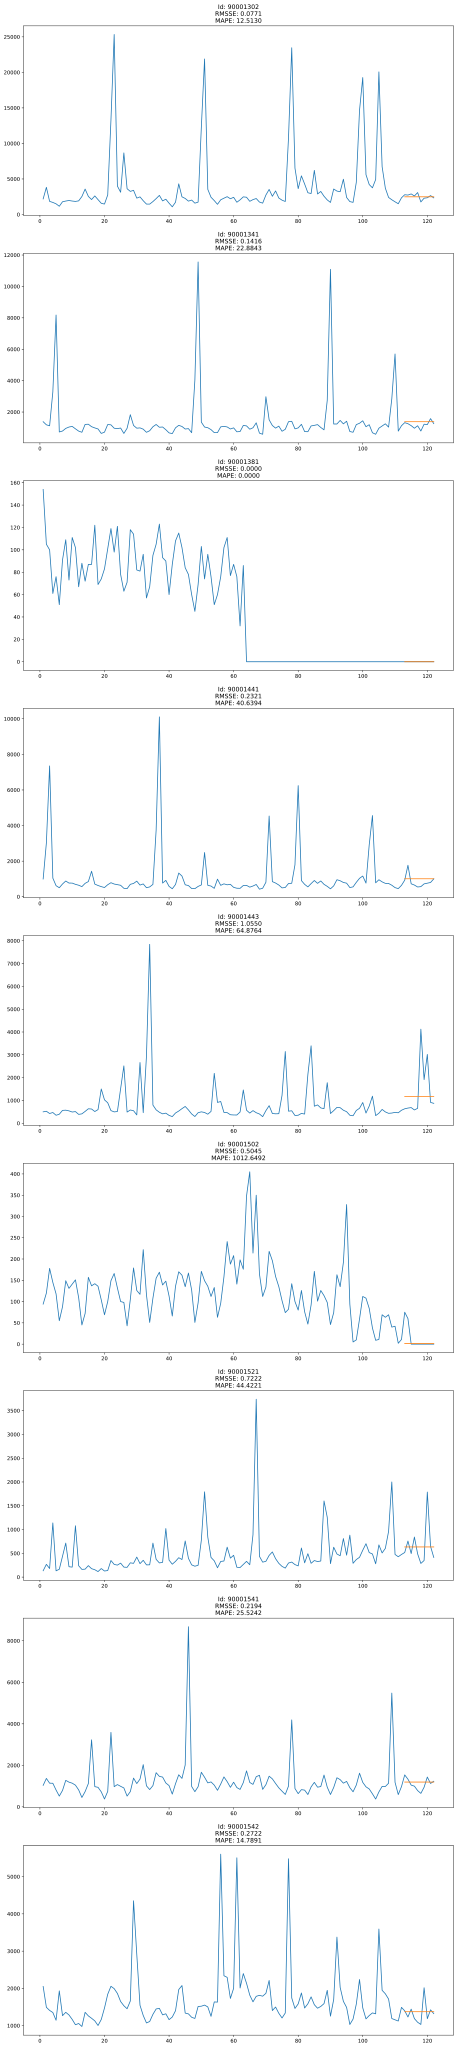

In [37]:
samples = len(prediction_des)

f, ax = plt.subplots(nrows=samples, ncols=1, figsize=(15,8*samples))

i = 0
des_rmsse=[]
des_mape=[]
for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries > 120:
        ax[i].plot(sliced.d, sliced.sold)
        ax[i].plot(sliced.d[-period:], prediction_des[identifier])
        
        rsse = rmsse(y_true=np.array(sliced.sold[-period:]), y_pred=prediction_des[identifier].values, 
             y_hist=np.array(sliced.sold))
        des_rmsse.append(rsse)    
        me = mape(np.array(sliced.sold[-period:]), prediction_des[identifier].values)
        des_mape.append(me)
        
        ax[i].set_title(f'Id: {identifier}\nRMSSE: {rsse:.4f}\nMAPE: {me:.4f}')

    
        i += 1

# f.savefig('./DES.pdf')

# (3) Prophet

In [38]:
prediction_des = {}


date_col = pd.date_range(start='20210301', end='20210630')
for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries == 122:
        sliced_copy = sliced.copy()
        sliced_copy['ds'] = date_col

        m = Prophet(
            weekly_seasonality=True,
            daily_seasonality=True,
            yearly_seasonality=True)
            
        temp = sliced_copy[sliced_copy['d'] < 122 - period][['ds', 'sold']]
        temp.rename(columns = {'sold':'y'}, inplace=True)
        
        m.fit(temp)
        
        future = m.make_future_dataframe(periods=period)
        
        prediction_des[identifier] = m.predict(future).iloc[-period:]

fig1 = m.plot(m.predict(future))

fig2 = m.plot_components(m.predict(future))

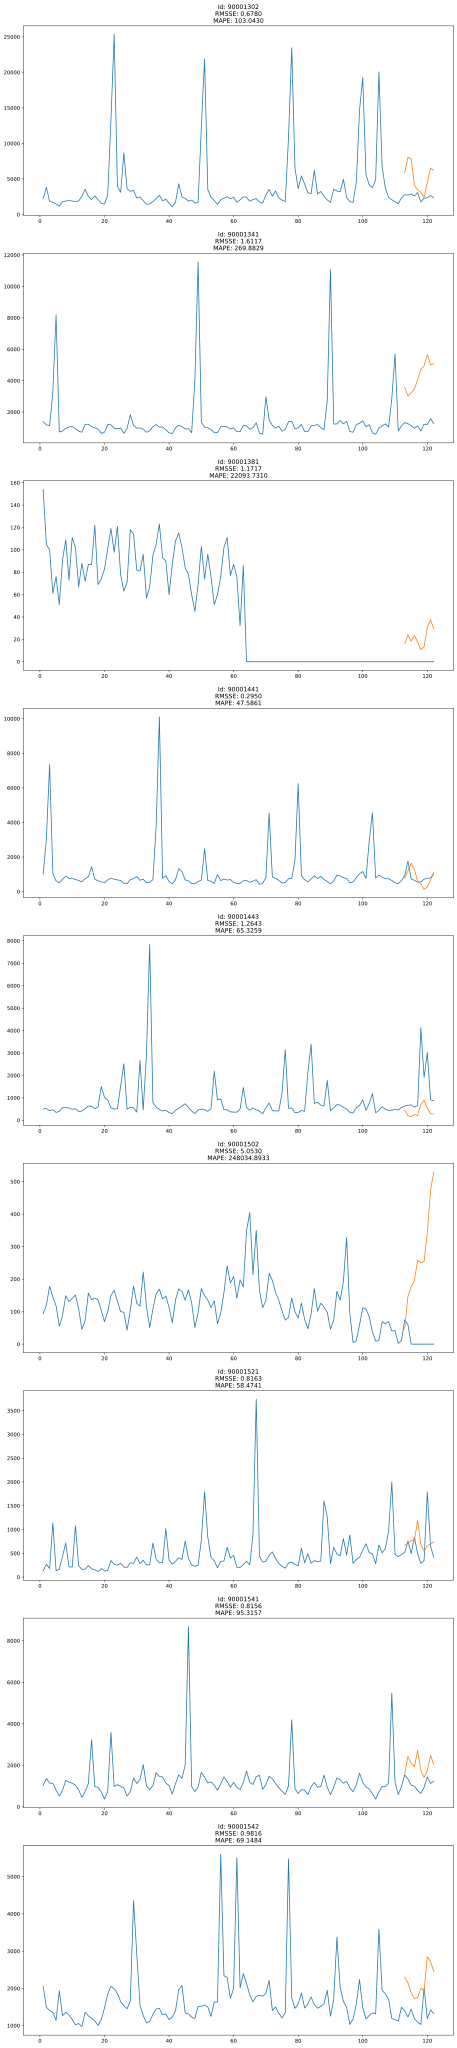

In [40]:
samples = len(prediction_des)

f, ax = plt.subplots(nrows=samples, ncols=1, figsize=(15,8*samples))

i = 0
prophet_rmsse=[]
prophet_mape=[]
for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries == 122:
        ax[i].plot(sliced.d, sliced.sold)
        ax[i].plot(sliced.d[-period:], prediction_des[identifier].yhat)
        
        rsse = rmsse(y_true=np.array(sliced.sold[-period:]), y_pred=prediction_des[identifier].yhat.values, 
                     y_hist=np.array(sliced.sold))
        prophet_rmsse.append(rsse)    
        me = mape(np.array(sliced.sold[-period:]), prediction_des[identifier].yhat.values)
        prophet_mape.append(me)
        
        ax[i].set_title(f'Id: {identifier}\nRMSSE: {rsse:.4f}\nMAPE: {me:.4f}')
        
        
        i += 1

# f.savefig('./Prophet.pdf')

# (4) LightGBM

In [41]:
from sklearn import preprocessing

le_week = preprocessing.LabelEncoder()
le_event = preprocessing.LabelEncoder()

le_week.fit(dataset['Week_day'])
le_event.fit(dataset['event_type'])

dataset['Week_day'] = le_week.transform(dataset['Week_day'])
dataset['event_type'] = le_event.transform(dataset['event_type'])

params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'metric': 'rmse', 
          'num_leaves': 160, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2021}

index = dataset['d']
last = index.max()

category_cols = ['event_type', 'Week_day']
prediction_des = {}

for identifier, sliced in dataset.groupby(['store_id']):
    train = sliced[index <= last - period].copy()
    test = sliced[index > last - period].copy()

    train_data = lgb.Dataset(train, label = train.sold, categorical_feature=category_cols)
    test_data = lgb.Dataset(test, label = test.sold, categorical_feature=category_cols)
    
    lgbmodel = lgb.train(params, train_data, valid_sets=[test_data],
                     early_stopping_rounds=200, verbose_eval=100)
    
    prediction_des[identifier] = lgbmodel.predict(test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 4
[LightGBM] [Info] Start training from score 3923.946429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 18.3617
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 18.3617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 4
[LightGBM] [Info] Start training from score 1056.991071
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

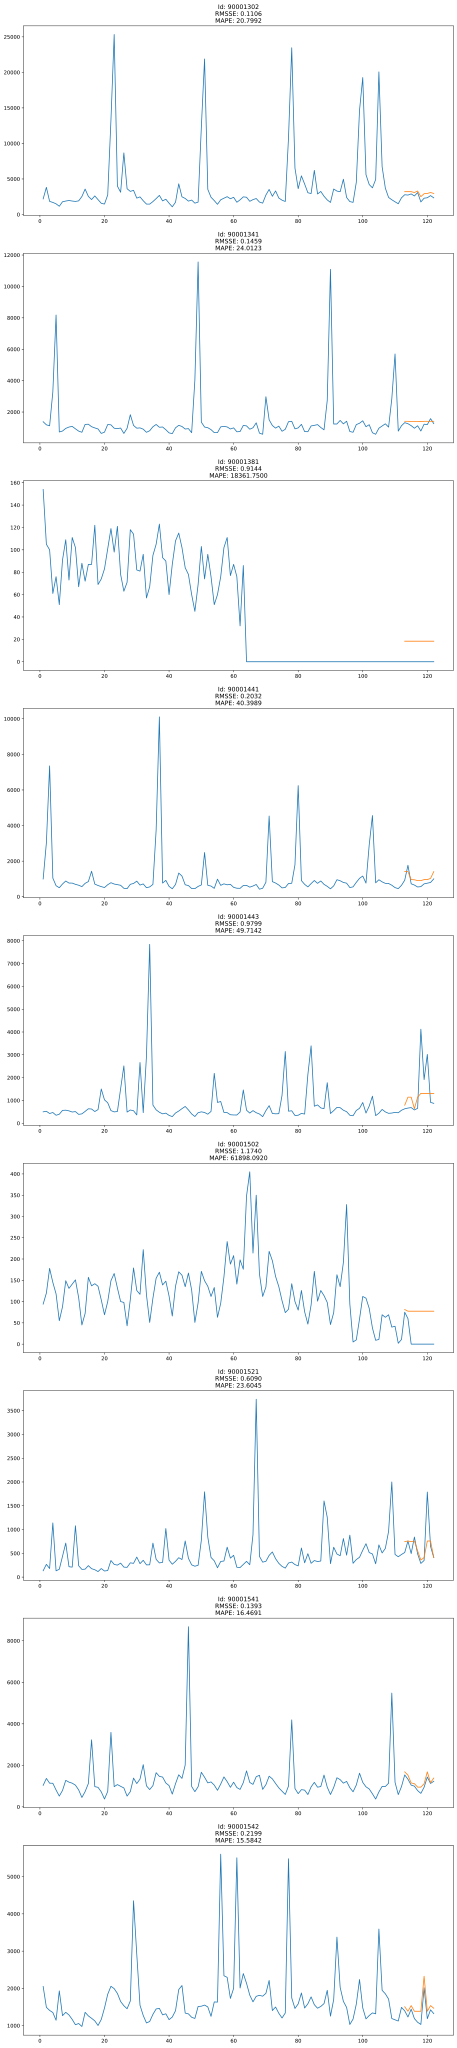

In [42]:
samples = len(prediction_des)

f, ax = plt.subplots(nrows=samples, ncols=1, figsize=(15,8*samples))

i = 0
lightgbm_rmsse=[]
lightgbm_mape=[]

for identifier, sliced in dataset.groupby(['store_id']):
    num_entries = len(sliced)
    
    if num_entries == 122:
        ax[i].plot(sliced.d, sliced.sold)
        ax[i].plot(sliced.d[-period:], prediction_des[identifier])
        
        rsse = rmsse(y_true=np.array(sliced.sold[-period:]), y_pred=prediction_des[identifier], 
                     y_hist=np.array(sliced.sold))
        prophet_rmsse.append(rsse)    
        me = mape(np.array(sliced.sold[-period:]), prediction_des[identifier])
        prophet_mape.append(me)
        
        ax[i].set_title(f'Id: {identifier}\nRMSSE: {rsse:.4f}\nMAPE: {me:.4f}')
        
        i += 1

# f.savefig('./Lightgbm.pdf')